# Importing libaries

In [1]:
#data processing and importing
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as plt 

#label encoder
from sklearn import preprocessing

#text transformation via spacy and keras 
import spacy
from keras.layers import TextVectorization
from tensorflow.keras import utils

#lstm model 
from keras import backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

***

# Importing and preparing the data

*Importing raw data*

In [2]:
#import speeches for 2021 as sample
speeches_df = pd.read_csv('data/speeches.csv')

In [3]:
#import faction id 
faction_df = pd.read_csv('data/factions.csv')
faction_df = faction_df.rename(columns={'id':'factionId'})

In [4]:
#merging the two dataframes
data = pd.merge(left = speeches_df, right = faction_df, on = 'factionId', how = 'inner')

In [5]:
#removing all speeches that are older than 5 years
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['date'])
data.sort_index(inplace=True, ascending=True)
data = data.loc['2015-10-01':]

In [6]:
#examining the
data.groupby('abbreviation').count()

,id,session,electoralTerm,firstName,lastName,politicianId,speechContent,factionId,documentUrl,positionShort,positionLong,fullName
abbreviation,,,,,,,,,,,,
AfD,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,0,4437
CDU/CSU,11511,11511,11511,11508,11508,11511,11511,11511,11511,11511,0,11511
DIE LINKE.,5574,5574,5574,5574,5574,5574,5573,5574,5574,5574,0,5574
FDP,3888,3888,3888,3888,3888,3888,3888,3888,3888,3888,0,3888
Fraktionslos,130,130,130,130,130,130,130,130,130,130,0,130
Grüne,6777,6777,6777,6777,6777,6777,6777,6777,6777,6777,0,6777
SPD,7732,7732,7732,7732,7732,7732,7731,7732,7732,7732,0,7732
not found,46724,46724,46724,46723,46724,46724,46706,46724,46724,46724,46203,46724


In [7]:
#dropping all columns that are not needed
data = data[['speechContent', 'abbreviation']]
data.rename(columns={'abbreviation':'partie'}, inplace=True)

In [8]:
#expecting the value count of all columns 
data.partie.value_counts()

not found       46724
CDU/CSU         11511
SPD              7732
Grüne            6777
DIE LINKE.       5574
AfD              4437
FDP              3888
Fraktionslos      130
Name: partie, dtype: int64

In [9]:
#removing all parties expect the biggest 6 parties of 2021 Germany 
data = data[data['partie'] != ('not found')]
data

,speechContent,partie
date,,
2015-10-01,Sehr geehrte Frau Präsidentin! Liebe Kolleginn...,CDU/CSU
2015-10-01,Frau Präsidentin! Liebe Kolleginnen und Kolleg...,CDU/CSU
2015-10-01,"Vielen Dank, Frau Präsidentin . - Ich wollte k...",CDU/CSU
2015-10-01,"Da habe ich ja noch mal Glück gehabt, Frau Prä...",CDU/CSU
2015-10-01,Da ich ebenfalls bei der Anhörung anwesend war...,CDU/CSU
...,...,...
2021-05-07,\n\nSehr geehrter Herr Präsident! Sehr geehrte...,Grüne
2021-05-07,\n\nSehr geehrter Herr Präsident! Liebe Kolleg...,Grüne
2021-05-07,\n\nWir brauchen eine gemeinsame Öffentlichkei...,Grüne


***

# Creating the dataframe

In [10]:
#adding a column "string_length" to the DataFrame
data[['speech_character_count']]= data['speechContent'].str.len()
data.groupby('partie')['speech_character_count'].min()

partie
AfD              5.0
CDU/CSU          5.0
DIE LINKE.       5.0
FDP              5.0
Fraktionslos    14.0
Grüne            5.0
SPD              5.0
Name: speech_character_count, dtype: float64

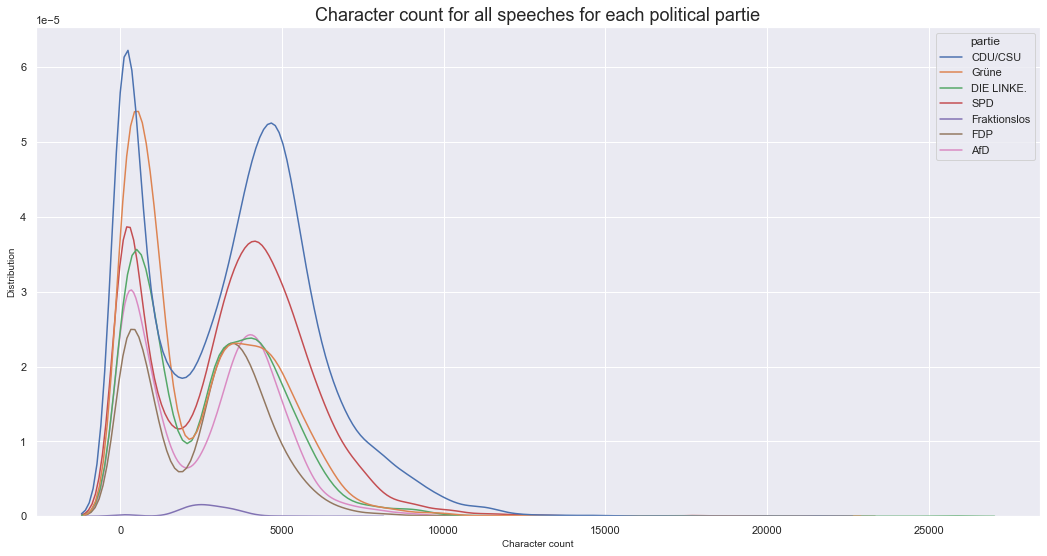

In [11]:
##distribution plot before reducing the amount of speeches
sns.set_theme(style="whitegrid", palette = "Set2")
sns.set(rc = {'figure.figsize':(18,9)})
sns.kdeplot(data=data, x='speech_character_count', hue = 'partie')
plt.pyplot.title(label = 'Character count for all speeches for each political partie', size = 18)
plt.pyplot.xlabel(xlabel = 'Character count', size = 10)
plt.pyplot.ylabel(ylabel = 'Distribution', size = 10);

In [12]:
#reducing the amount of data
data = data.loc[data['speech_character_count'] >= 3900]
data.groupby('partie')['speechContent'].count()

partie
AfD             1528
CDU/CSU         5644
DIE LINKE.      1850
FDP             1045
Fraktionslos       5
Grüne           1977
SPD             3547
Name: speechContent, dtype: int64

In [13]:
#creating small samples of speeches, for each political party only 50 
max_number_speeches = 800

cdu_csu = data[data['partie'] == 'CDU/CSU'][:max_number_speeches]
spd = data[data['partie'] == 'SPD'][:max_number_speeches]
fdp = data[data['partie'] == 'FDP'][:max_number_speeches]
afd = data[data['partie'] == 'AfD'][:max_number_speeches]
gruene = data[data['partie'] == 'Grüne'][:max_number_speeches]
linke = data[data['partie'] == 'DIE LINKE.'][:max_number_speeches]

data = pd.concat([cdu_csu, spd, fdp, afd, gruene, linke], ignore_index=True)

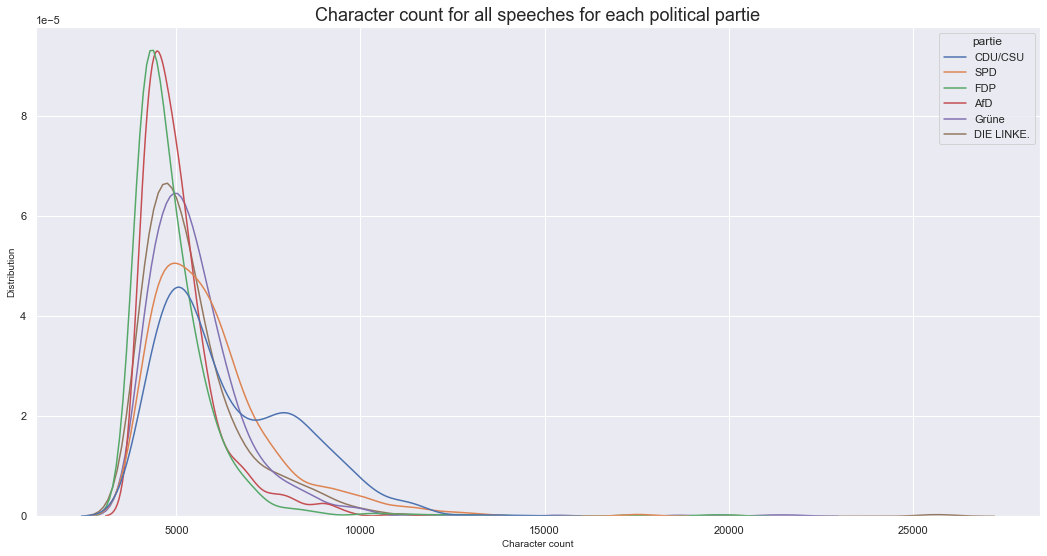

In [14]:
#distribution plot after reducing the amount of speeches
sns.set_theme(style="whitegrid", palette = "Set2")
sns.set(rc = {'figure.figsize':(18,9)})
sns.kdeplot(data=data, x='speech_character_count', hue = 'partie')
plt.pyplot.title(label = 'Character count for all speeches for each political partie', size = 18)
plt.pyplot.xlabel(xlabel = 'Character count', size = 10)
plt.pyplot.ylabel(ylabel = 'Distribution', size = 10);

***

# Checking the length of all speeches

In [15]:
#checking the minimal character count
min_length = int(data['speech_character_count'].min()) #The int() method returns an integer object from any number or string
print(f'The minimal length of one speech is {min_length}.')

The minimal length of one speech is 3900.


In [16]:
#checking the maximial character count
max_length = int(data['speech_character_count'].max()) #The int() method returns an integer object from any number or string
print(f'The maximal length of one speech is {max_length}.')

The maximal length of one speech is 25838.


In [17]:
#checking the median character count for all speeches
median_length = int(data['speech_character_count'].median()) #The int() method returns an integer object from any number or string
print(f'The length of the median for all speeches is {median_length}.')

The length of the median for all speeches is 5118.


In [18]:
#checking the average character count for all speech 
mean_length = int(data['speech_character_count'].mean())
print(f'The length of the mean for all speeches is {mean_length}.')

The length of the mean for all speeches is 5576.


***

# Cleaning the speeches using RegEx

Remarks: Since I want to include grammatical information in my model’s input vectors, I don’t want to remove stopwords or lemmatize words. Also, as capitilazation is very crucial in the German language, I did not lower the single words. I only removed special characters via RegEx, did vectorizing via word embedding and padding. 

*RegEx*

In [19]:
#defining X_series and y_series
X_series = data['speechContent']
y_series = data['partie']

In [20]:
#examining X_series
X_series.head()

0    Sehr geehrte Frau Präsidentin! Liebe Kolleginn...
1    Frau Präsidentin! Liebe Kolleginnen und Kolleg...
2    Da habe ich ja noch mal Glück gehabt, Frau Prä...
3    Sehr geehrte Frau Präsidentin! Verehrte Kolleg...
4    Sehr geehrte Frau Präsidentin! Liebe Kolleginn...
Name: speechContent, dtype: object

In [21]:
X_series[18]  

'Frau Präsidentin! Liebe Kolleginnen und Kollegen!\n\nMeine sehr verehrten Damen und Herren! Wir haben\nim Parlament heute früh wie auch vorhin während der\nMenschenrechtsdebatte beeindruckend erlebt, wie sich\nunser Parlament die Frage der Flüchtlinge im Inland zu\nHerzen nimmt . In der jetzigen Debatte geht es darum,\nwie wir als Europäische Union mit der Flüchtlingslage an\nden europäischen Grenzen umgehen . 22 Mitgliedstaaten\nder Europäischen Union engagieren sich in der Mission\nEUNAVFOR MED, diese stellen neun Schiffe und zwölf\nLuftfahrzeuge zur Verfügung . Das ist ein Zeichen euro\xad\npäischer Solidarität, aber es ist eben auch nur ein Teil der\nnotwendigen Strategie, die wir brauchen .\n\nHerr Dr . Neu, ich weise eindeutig zurück, was Sie hier\nangesprochen haben . Wenn Sie den Operationsplan ge\xad\nnau lesen,\n\n({0})\n\ndann werden Sie feststellen, dass eine Abweisung der\nSchiffe nicht vorgesehen ist .\n\n({1})\n\nEs kann aber sein, dass Sie den nötigen Annex nicht lesen

In [22]:
#cleaning the speeches using regex
def clean_speech(series_speech):
    series_speech = series_speech.str.replace('\n',' ', regex = True) #removes all newlines 
    series_speech = series_speech.str.replace('\xa0','', regex = True) #removes all \xa0
    series_speech = series_speech.str.replace('\xad','', regex = True) #removes all \xa0
    series_speech = series_speech.str.replace(',','', regex = True) #removes all commas
    series_speech = series_speech.str.replace('?','', regex = True) #removes all ?
    series_speech = series_speech.str.replace('!','', regex = True) #removes all !
    series_speech = series_speech.str.replace('.','', regex = True) #removes all .
    series_speech = series_speech.str.replace('-','', regex = True) #removes all -
    series_speech = series_speech.str.replace(':','', regex = True) #removes all :
    series_speech = series_speech.str.replace(';','', regex = True) #removes all ;
    series_speech = series_speech.str.replace('„','', regex = True) #removes all „
    series_speech = series_speech.str.replace('“','', regex = True) #removes all “
    series_speech = series_speech.str.replace('/','', regex = True) #removes all /
    series_speech = series_speech.str.replace('(','', regex = True) #removes all (
    series_speech = series_speech.str.replace(')','', regex = True) #removes all )
    series_speech = series_speech.str.replace('{','', regex = True) #removes all {
    series_speech = series_speech.str.replace('}','', regex = True) #removes all )
    series_speech = series_speech.str.replace('[0-9]','', regex = True) #removes all digits
    return series_speech


X_series = clean_speech(X_series)

In [23]:
#final check-up
len(X_series)              #checking if the length of the list is still 1200 
X_series[18]                #expecting single speeches for check-up

'Frau Präsidentin Liebe Kolleginnen und Kollegen  Meine sehr verehrten Damen und Herren Wir haben im Parlament heute früh wie auch vorhin während der Menschenrechtsdebatte beeindruckend erlebt wie sich unser Parlament die Frage der Flüchtlinge im Inland zu Herzen nimmt  In der jetzigen Debatte geht es darum wie wir als Europäische Union mit der Flüchtlingslage an den europäischen Grenzen umgehen   Mitgliedstaaten der Europäischen Union engagieren sich in der Mission EUNAVFOR MED diese stellen neun Schiffe und zwölf Luftfahrzeuge zur Verfügung  Das ist ein Zeichen euro päischer Solidarität aber es ist eben auch nur ein Teil der notwendigen Strategie die wir brauchen   Herr Dr  Neu ich weise eindeutig zurück was Sie hier angesprochen haben  Wenn Sie den Operationsplan ge nau lesen    dann werden Sie feststellen dass eine Abweisung der Schiffe nicht vorgesehen ist     Es kann aber sein dass Sie den nötigen Annex nicht lesen durften weil Sie die notwendige Sicherheitsüberprüfung nicht habe

***

# Creating tokens out of all speeches

In [24]:
#cleaning the keras sessions
K.clear_session()

In [25]:
#loading spacy & text vectorization
nlp = spacy.load('de_core_news_md')                             #loading the German word embedding from spacy with a vector length of 300
Vectorizer = TextVectorization(output_sequence_length=4000)      #keras.TextVectorization with a truncating / padding of 6000 as it seems to be good size for a speech (mode is 5673)

2021-12-15 17:27:04.161132: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(X_series)          #training the Vectorizer on the speeches
vocab = Vectorizer.get_vocabulary() #retrieving and tokenizing the unique vocabulary 
vocab[5]                            #inspecting the first tokens

'das'

In [27]:
#how many tokens (single words) are there?
num_token= len(vocab) 
print(f'The Vectorizer produced {num_token} unique tokenized words.')

The Vectorizer produced 121676 unique tokenized words.


***

# Creating the embedding matrix

In [28]:
#observing and saving the length of one vector
embedding_dim = len(nlp('test').vector)
embedding_dim

300

In [29]:
#creating an empty embedding matrix in the size of num_tokens & embedding_dim
embedding_matrix = np.zeros((num_token, embedding_dim)) #84170 unique words & 300 length of vector
embedding_matrix.shape              

(121676, 300)

In [30]:
#check: the embedding matrix should be a completely empty scaffolding
embedding_matrix[1] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
#mapping the empty embedding matrix to the nlp word vector
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(str(word)).vector

#check: the embedding matrix should be filled with vectors
embedding_matrix[1]

array([ 7.66302347e+00, -3.04783320e+00,  8.43063259e+00,  7.05233276e-01,
        7.47413301e+00,  4.21750021e+00,  3.01593328e+00, -1.16249990e+00,
       -8.99026680e+00, -4.24296665e+00,  9.13333237e-01,  1.51676655e+00,
       -1.36577330e+01, -7.77346659e+00,  2.60878658e+00,  4.69158030e+00,
        1.22510004e+00, -2.02659988e+00, -1.90441835e+00, -7.28933334e-01,
        3.71933341e+00, -2.72500992e+00,  2.08066627e-01,  4.39003325e+00,
       -6.74666703e-01, -5.62376618e-01,  1.19014335e+00, -1.32821321e+00,
       -8.22983265e+00, -8.47583294e+00,  4.45953321e+00, -4.58010006e+00,
       -1.43885672e+00,  3.03533226e-01,  6.62133360e+00,  8.11399937e+00,
        5.13896656e+00, -3.30943322e+00,  7.46803331e+00,  6.16405344e+00,
       -1.54566765e-01, -4.67240000e+00,  3.38960004e+00, -1.20480335e+00,
        6.56593323e+00,  2.69933319e+00,  3.05713367e+00, -2.64813328e+00,
        1.23017664e+01,  1.62923023e-01, -5.75076675e+00,  1.88002670e+00,
       -6.25394011e+00,  

***

# Preprocessing the speeches (X)

In [32]:
#vectorizing and truncating/padding of all speeches
X = Vectorizer(np.array([[word] for word in X_series])).numpy()
X.shape #4800 speeches, each speech has 4000 words

(4800, 4000)

In [33]:
#checking out X
X[1]

array([ 87, 183,  89, ...,   0,   0,   0])

***

# Preprocessing the labels (y)

In [34]:
#transforming the parties into labels 
le = preprocessing.LabelEncoder()
le.fit(y_series)
labels = le.transform(y_series) #the names of the political parties are transformed into numbers in [0,1,2,3,4,5]
labels

array([1, 1, 1, ..., 2, 2, 2])

In [35]:
#one_hot_encoding of labels
y = utils.to_categorical(labels, num_classes=6)
y.shape

(4800, 6)

In [36]:
#testing if the labels & one-hot-encoding of the labels worked
labels[:5] , y[:5]  #yes, it worked!

(array([1, 1, 1, 1, 1]),
 array([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32))

***

# Building the LSTM model

<i>input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words. <br><br>
output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem. <br><br>
input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.</i>

In [37]:
model = Sequential()
model.add(Embedding(input_dim = num_token, output_dim = embedding_dim, input_length=4000, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)) #trainable = False, for this layer not trained - also good against overfitting
model.add(Bidirectional(LSTM(64)))                     #first start small, than max up the number
model.add(Dense(6, activation='softmax'))                   #softmax activation, last layer should have 6 neurons as there are 6 parties
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4000, 300)         36502800  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 36,690,454
Trainable params: 187,654
Non-trainable params: 36,502,800
_________________________________________________________________
None


***

# Fitting the LSTM model

In [38]:
#fitting the model
history = model.fit(X, y, batch_size = 50, epochs = 10)

Epoch 1/10
15/96 [===>..........................] - ETA: 6:22 - loss: 1.7513 - acc: 0.2293

KeyboardInterrupt: 

***

# Classifying new text

In [ ]:
#inserting a new text 
speech_new = ['test test eins zwei drei']

In [ ]:
#cleaning, vectorizing and truncating/padding of the new text 
def clean_padd_vector_speech_new(speech_new):
    '''
    Function that 1) cleans, 2) padds or truncats and, 3) vectorizes an unseen speech of a German political partie 
    Argument(s): Variable that contains a list of an unseen speech
    Return: Cleaned, padded/truncated and vectorized speech as X 
    '''
    speech_new_series = pd.Series(speech_new) #creates a series out of the inserted speech
    speech_new = clean_speech(speech_new_series) #uses the clean_speech function to apply RegEx cleaning to the inserted speech
    X = Vectorizer(np.array([[word] for word in speech_new])).numpy() #vectorizes and padds/truncates the new speech
    return X

In [ ]:
#inspecting X 
clean_padd_vector_speech_new(speech_new)
X[0]

array([ 53, 250,  87, ...,   0,   0,   0])

In [ ]:
#creating ypred
ypred = []
ypred.append(model.predict(X))

KeyboardInterrupt: 

In [ ]:
#looking at ypred 
print(f'The LSTM Model classified the unseen speech as follows: CDU/CSU: {round(ypred[0],2)}, SPD: {round(ypred[1],2)}, FDP: {round(ypred[2],2)}, AfD: {round(ypred[3],2)}, Grüne: {round(ypred[4],2)}, DIE LINKE.: {round(ypred[5],2)}')

IndexError: list index out of range